# Inspect Cityscapes Cooked Class Frequencies

In [1]:
# Standard
from collections import Counter
import os
import pickle
import time
from typing import Dict, List

# Visualization
from matplotlib import pyplot as plt

# Numerics
import numpy as np

# Machine Learning
import albumentations as albm  # Faster than `torchvision.transforms`.
import pytorch_lightning as pl

In [2]:
# Project-Specific
from core import (
    SemanticClassId,
    SparseLabelSimulatingDataset,
    compute_semantic_class_num_pixels,
    compute_semantic_class_frequencies,
    smooth_semantic_class_frequencies,
    compute_semantic_class_weights,
)
from core.visualization import (
    plot_semantic_class_frequencies,
    plot_semantic_class_weights,
)
from data.cityscapes import (
    class_mapping,
    preprocesses_from,
    subcityscapes_dataset,
    cityscapes_dataset,
    TargetClassNumPixelsCache,
)

In [3]:
REPO_ROOT: str = os.environ.get("REPO_ROOT")
assert REPO_ROOT is not None, \
    "REPO_ROOT not found! Did you run `setenv.sh` before serving the notebook?"
CITYSCAPES_DATA_ROOT: str = os.path.join(REPO_ROOT, "data/cityscapes")

In [4]:
preprocesses: Dict[str, albm.Compose] = preprocesses_from(
    input_height=320,
    input_width=640,
    mean_for_input_normalization=(0.485, 0.456, 0.406),
    std_for_input_normalization=(0.229, 0.224, 0.225),
    #do_shift_scale_rotate=...,  # Not relevant here since we're only using
    #ignore_index=...,           # the "infer" preprocessing.    
)
preprocess: albm.Compose = preprocesses["infer"]

In [5]:
num_pixels_cache_filename: str = os.path.join(
    REPO_ROOT,
    "src/data/cityscapes/",
    "target_class_num_pixels_cache.pkl",
)
with open(num_pixels_cache_filename, "rb") as fin:
    target_class_num_pixels_cache: TargetClassNumPixelsCache = pickle.load(fin)

In [6]:
subcityscapes_train: SparseLabelSimulatingDataset = subcityscapes_dataset(
    split="train",  # "train", "val", "trainval", or "test".
    preprocess=preprocess,
    len_scale_factor=1.0,
    label_density=1.0,
    ignore_index=255,
    shuffle=False,
    target_class_num_pixels=target_class_num_pixels_cache.get(
        dataset_name="subcityscapes_train",
        len_scale_factor=1.0,
        label_density=1.0,
    ),
)
subcityscapes_val: SparseLabelSimulatingDataset = subcityscapes_dataset(
    split="val",  # "train", "val", "trainval", or "test".
    preprocess=preprocess,
    len_scale_factor=1.0,
    label_density=1.0,
    ignore_index=255,
    shuffle=False,
    target_class_num_pixels=target_class_num_pixels_cache.get(
        dataset_name="subcityscapes_val",
        len_scale_factor=1.0,
        label_density=1.0,
    ),
)
subcityscapes_trainval: SparseLabelSimulatingDataset = subcityscapes_dataset(
    split="trainval",  # "train", "val", "trainval", or "test".
    preprocess=preprocess,
    len_scale_factor=1.0,
    label_density=1.0,
    ignore_index=255,
    shuffle=False,
    target_class_num_pixels=target_class_num_pixels_cache.get(
        dataset_name="subcityscapes_trainval",
        len_scale_factor=1.0,
        label_density=1.0,
    ),
)
subcityscapes_test: SparseLabelSimulatingDataset = subcityscapes_dataset(
    split="test",  # "train", "val", "trainval", or "test".
    preprocess=preprocess,
    len_scale_factor=1.0,
    label_density=1.0,
    ignore_index=255,
    shuffle=False,
    target_class_num_pixels=target_class_num_pixels_cache.get(
        dataset_name="subcityscapes_test",
        len_scale_factor=1.0,
        label_density=1.0,
    ),
)

In [7]:
cityscapes_train: SparseLabelSimulatingDataset = cityscapes_dataset(
    split="train",  # "train", "val", "trainval", or "test".
    preprocess=preprocess,
    len_scale_factor=1.0,
    label_density=1.0,
    ignore_index=255,
    shuffle=False,
    target_class_num_pixels=target_class_num_pixels_cache.get(
        dataset_name="cityscapes_train",
        len_scale_factor=1.0,
        label_density=1.0,
    ),
)
cityscapes_val: SparseLabelSimulatingDataset = cityscapes_dataset(
    split="val",  # "train", "val", "trainval", or "test".
    preprocess=preprocess,
    len_scale_factor=1.0,
    label_density=1.0,
    ignore_index=255,
    shuffle=False,
    target_class_num_pixels=target_class_num_pixels_cache.get(
        dataset_name="cityscapes_val",
        len_scale_factor=1.0,
        label_density=1.0,
    ),
)
cityscapes_trainval: SparseLabelSimulatingDataset = cityscapes_dataset(
    split="trainval",  # "train", "val", "trainval", or "test".
    preprocess=preprocess,
    len_scale_factor=1.0,
    label_density=1.0,
    ignore_index=255,
    shuffle=False,
    target_class_num_pixels=target_class_num_pixels_cache.get(
        dataset_name="cityscapes_trainval",
        len_scale_factor=1.0,
        label_density=1.0,
    ),
)

In [8]:
# Inspect the class frequencies of this dataset
dataset: SparseLabelSimulatingDataset = subcityscapes_train

---

## Plot Class Frequencies

In [9]:
start_time: float = time.time()

target_class_num_pixels: List[Counter[SemanticClassId]] = \
    dataset.target_class_num_pixels

class_num_pixels: Counter[SemanticClassId] = \
    compute_semantic_class_num_pixels(
        class_mapping=class_mapping,
        target_class_num_pixels=target_class_num_pixels,
    )

print(f"Elapsed time = {time.time() - start_time:.2f} s")

Elapsed time = 0.01 s


In [10]:
frequencies: np.ndarray = \
    compute_semantic_class_frequencies(class_num_pixels)
print(f"minimum frequency: {class_mapping.class_names[frequencies.argmin()]} @ {frequencies.min()}")
print(f"maximum frequency: {class_mapping.class_names[frequencies.argmax()]} @ {frequencies.max()}")
print(f"max/min: {frequencies.max()/frequencies.min()}")

minimum frequency: motorcycle @ 0.0008928732438520952
maximum frequency: road @ 0.3264392606176511
max/min: 365.605378888166


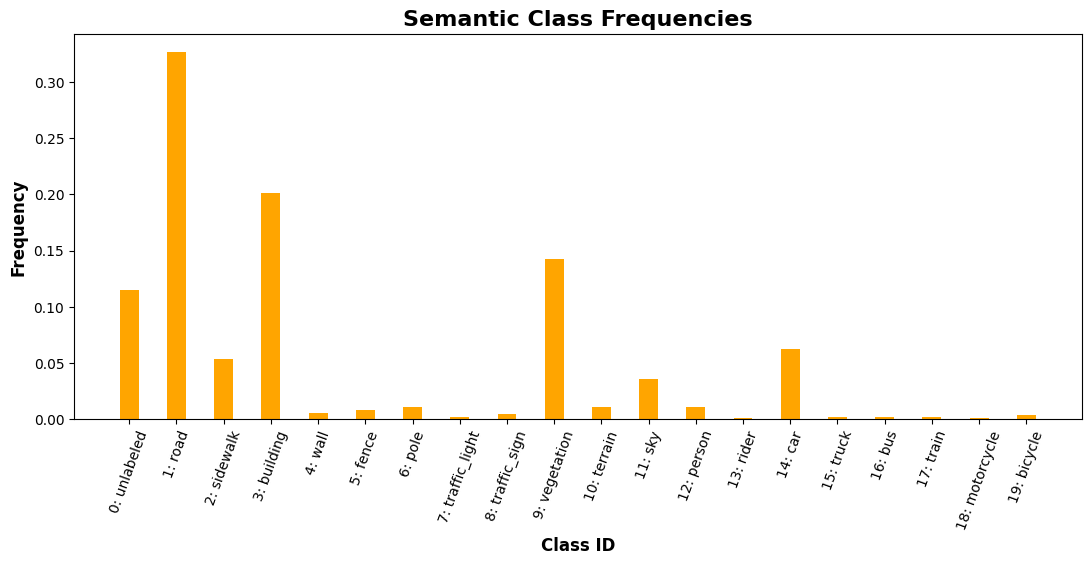

In [11]:
plt.figure(figsize = (13, 5))
# plt.rc("text", usetex=True)
plot_semantic_class_frequencies(
    class_names=class_mapping.class_names,
    class_frequencies=frequencies,
    # title=r"SubCityscapes Training+Validation Semantic Class Frequencies",
    # title="SubCityscapes Semantic Class Frequencies",
    title="Semantic Class Frequencies",
)
# plt.show()
# plt.savefig(
#     os.path.join(evaluation_dirname, "foo.png"),
#     bbox_inches="tight",
#     pad_inches=0.05,
#     #dpi=500,
# )

---

## Compute and Plot Semantic Class Weights

In [12]:
weights: np.ndarray = compute_semantic_class_weights(frequencies)

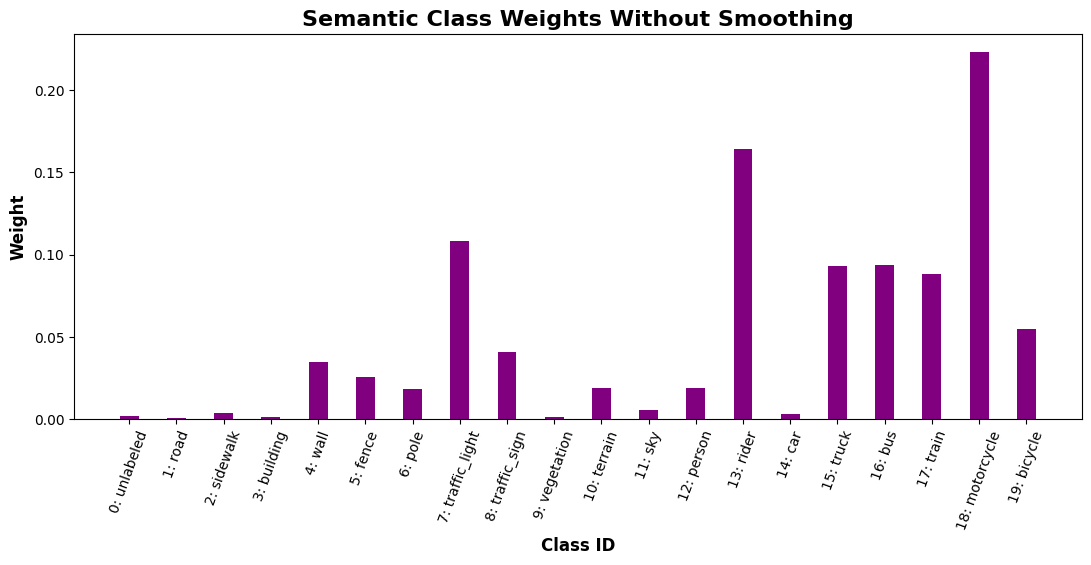

In [13]:
plt.figure(figsize = (13, 5))
plot_semantic_class_weights(
    class_names=class_mapping.class_names,
    class_weights=weights,
    title="Semantic Class Weights Without Smoothing",
)

In [14]:
frequencies_smooth: np.ndarray = smooth_semantic_class_frequencies(
    class_frequencies=frequencies,
    frequency_max_to_min_ratio_ubnd=5.0,
)
print(frequencies_smooth)

[0.07484748 0.15592052 0.05142392 0.1078764  0.03304935 0.03381507
 0.03496263 0.03154507 0.03270644 0.08532271 0.03485093 0.04440432
 0.03492565 0.03130592 0.0545978  0.03166379 0.03165838 0.0317058
 0.0311841  0.03223372]


In [15]:
if False:
    plt.figure(figsize = (13, 5))
    plot_semantic_class_frequencies(
        class_names=class_mapping.class_names,
        class_frequencies=frequencies_smooth,
        # title="SubCityscapes Semantic Class Frequencies",
        title="Semantic Class Frequencies",
    )

In [16]:
weights_smooth: np.ndarray = \
    compute_semantic_class_weights(frequencies_smooth)

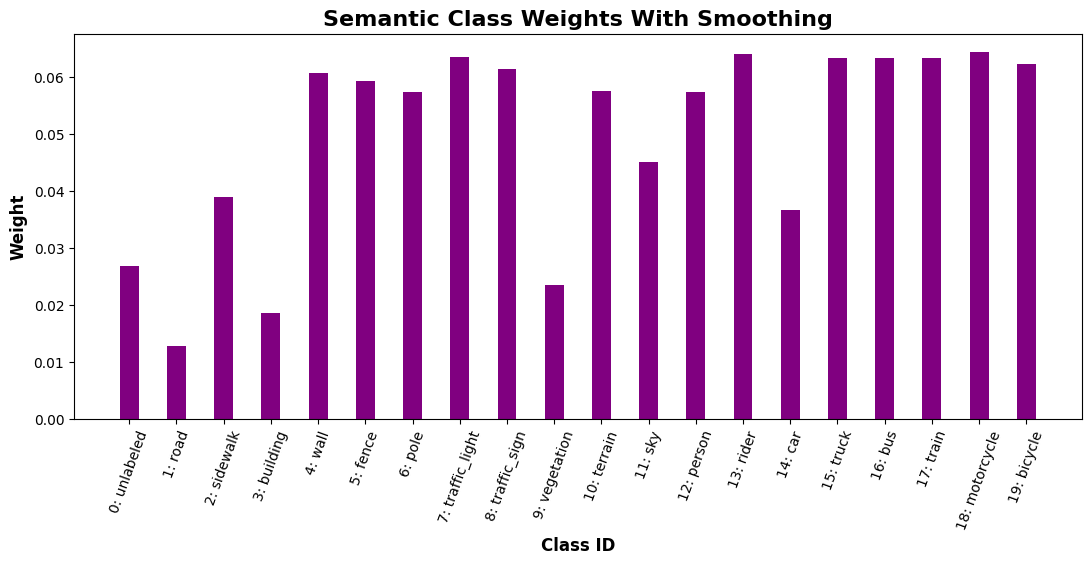

In [17]:
plt.figure(figsize = (13, 5))
plot_semantic_class_weights(
    class_names=class_mapping.class_names,
    class_weights=weights_smooth,
    title="Semantic Class Weights With Smoothing",
)